In [93]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
import seaborn as sns
import pyfolio as pf
from WindPy import w
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sns.set(style="darkgrid")

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

# 读取数据

### 通过wind接口读取

In [4]:
# contract = "IF00.CFE" # 沪深300期货当月
# contract = "CU03.SHF" # 沪铜连三
contract = "TF01.CFE"

In [60]:
raw = w.wsd(contract, "close", beginTime="2002-01-01", endTime="2017-01-17")

In [61]:
raw

.ErrorCode=0
.Codes=[TF01.CFE]
.Fields=[CLOSE]
.Times=[20020104,20020107,20020108,20020109,20020110,20020111,20020114,20020115,20020116,20020117,...]
.Data=[[nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...]]

In [62]:
dic = {}
for data, field in zip(raw.Data, raw.Fields):
    dic[str.lower(str(field))] = data

In [63]:
df = pd.DataFrame(dic, index=raw.Times)

In [73]:
raw_df = df.copy().dropna()

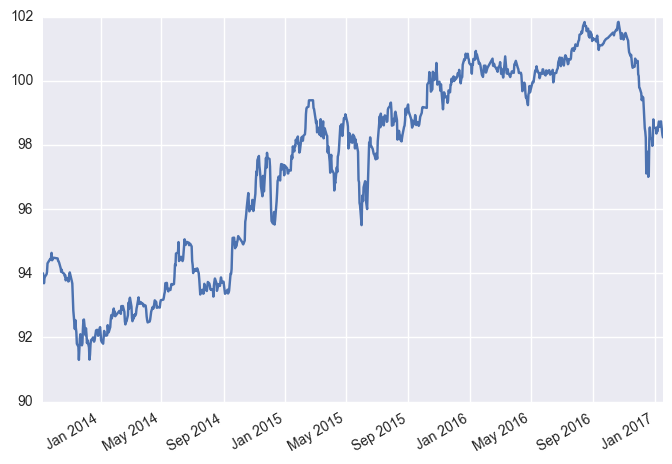

In [74]:
raw_df["close"].plot()

# 提取每日收益

In [75]:
def daily_return(df):
    df[contract] = df["close"].pct_change()
    return df[contract]

In [76]:
day_return = daily_return(df)

In [77]:
day_return.dropna(inplace=True)

In [78]:
day_return.head()

2013-09-09 00:00:00.005   -0.003054
2013-09-10 00:00:00.005   -0.000745
2013-09-11 00:00:00.005   -0.002576
2013-09-12 00:00:00.005    0.001644
2013-09-13 00:00:00.005    0.000533
Name: TF01.CFE, dtype: float64

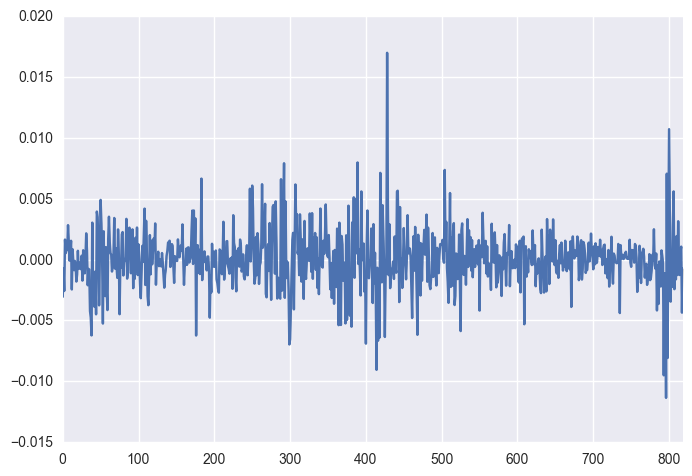

In [79]:
sns.tsplot(day_return)

# 计算波动率
$$\sigma^2_t=261\sum^\infty_{i=0}(1-\delta)\delta^i(r_{t-1-i}-\bar{r}_t)^2$$

In [80]:
day_vol = day_return.ewm(ignore_na=False, adjust=True, com=60, min_periods=0).std(bias=False)

In [81]:
vol = day_vol * np.sqrt(261) # annualise

# 计算Time Series Momentum (TSMOM)
$$TSMOM_{t+1}^{X-month} = \text{sign(excess return of s over past X month)} \frac{40%}{\sigma_t^s}r_{t+1}^s$$


### 提取monthly return和volatility

In [82]:
std_index = day_return.resample("BM").last() # month index

In [83]:
ret_index = (1 + day_return).cumprod()

In [84]:
ret_index[0] = 1

In [85]:
ret_index = pd.concat([ret_index, vol], axis=1)
ret_index.columns = [contract, "%s_vol"%(contract)]

In [86]:
ret_m_index = ret_index.resample('BM').last().ffill()

In [87]:
ret_m_index.ix[0][contract] = 1

In [88]:
ret_m_index.head()

,TF01.CFE,TF01.CFE_vol
2013-09-30,1.000000,0.027965
2013-10-31,0.996479,0.021153
2013-11-29,0.981652,0.039709
2013-12-31,0.979128,0.037939
2014-01-31,0.982734,0.035469


### (Short/Medium/Long Term) TSMOM Strategy

In [89]:
target_vol = 0.4
look_back = 6

In [90]:
std_index = ret_m_index.index
pnl = pd.DataFrame(index=std_index)
leverage = pd.DataFrame(index=std_index)

In [91]:
df = ret_m_index.copy()

In [96]:
df["return"] = df[contract].pct_change(look_back)
df["pnl"] = 0.0
df["leverage"] = 0.0
long_markers = []
short_markers = []
for k, v in enumerate(df["return"]):
    if k <= look_back:
        continue
    if df["return"].iloc[k - 1] < 0:
        df["pnl"].iloc[k] = (df[contract].iloc[k - 1] / df[contract].iloc[k] - 1) *\
                            target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        df["leverage"].iloc[k] = target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        short_markers.append(df.index[k - 1])
        print("%s: short %.2f%% shares, return: %.2f"%
              (df.index[k - 1].strftime("%Y-%m-%d"), target_vol / df["%s_vol"%(contract)].iloc[k - 1], df["pnl"].iloc[k]))
    else:
        df["pnl"].iloc[k] = (df[contract].iloc[k] / df[contract].iloc[k - 1] - 1) *\
                            target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        df["leverage"].iloc[k] = target_vol / df["%s_vol"%(contract)].iloc[k - 1]
        long_markers.append(df.index[k - 1])
        print("%s: long %.2f%% shares, return: %.2f"%
              (df.index[k - 1].strftime("%Y-%m-%d"), target_vol / df["%s_vol"%(contract)].iloc[k - 1], df["pnl"].iloc[k]))
    # print k, df["pnl"].iloc[k]
pnl = pd.concat([pnl, df["pnl"]], axis=1)
leverage = pd.concat([leverage, df["leverage"]], axis=1)

2014-03-31: short 12.56% shares, return: -0.02
2014-04-30: short 14.20% shares, return: -0.22
2014-05-30: long 14.37% shares, return: 0.03
2014-06-30: long 13.14% shares, return: -0.17
2014-07-31: long 13.41% shares, return: 0.02
2014-08-29: long 14.28% shares, return: 0.22
2014-09-30: long 12.75% shares, return: 0.12
2014-10-31: long 11.81% shares, return: 0.19
2014-11-28: long 9.41% shares, return: -0.02
2014-12-31: long 8.74% shares, return: 0.04
2015-01-30: long 9.59% shares, return: 0.13
2015-02-27: long 10.16% shares, return: -0.20
2015-03-31: long 9.37% shares, return: 0.18
2015-04-30: long 8.62% shares, return: -0.25
2015-05-29: short 8.03% shares, return: -0.13
2015-06-30: long 6.72% shares, return: 0.06
2015-07-31: long 7.33% shares, return: 0.05
2015-08-31: long 7.98% shares, return: -0.00
2015-09-30: long 9.05% shares, return: 0.07
2015-10-30: long 8.80% shares, return: 0.02
2015-11-30: long 9.47% shares, return: 0.04
2015-12-31: long 10.64% shares, return: -0.01
2016-01-29

In [97]:
long_markers

[Timestamp('2014-05-30 00:00:00', offset='BM'),
 Timestamp('2014-06-30 00:00:00', offset='BM'),
 Timestamp('2014-07-31 00:00:00', offset='BM'),
 Timestamp('2014-08-29 00:00:00', offset='BM'),
 Timestamp('2014-09-30 00:00:00', offset='BM'),
 Timestamp('2014-10-31 00:00:00', offset='BM'),
 Timestamp('2014-11-28 00:00:00', offset='BM'),
 Timestamp('2014-12-31 00:00:00', offset='BM'),
 Timestamp('2015-01-30 00:00:00', offset='BM'),
 Timestamp('2015-02-27 00:00:00', offset='BM'),
 Timestamp('2015-03-31 00:00:00', offset='BM'),
 Timestamp('2015-04-30 00:00:00', offset='BM'),
 Timestamp('2015-06-30 00:00:00', offset='BM'),
 Timestamp('2015-07-31 00:00:00', offset='BM'),
 Timestamp('2015-08-31 00:00:00', offset='BM'),
 Timestamp('2015-09-30 00:00:00', offset='BM'),
 Timestamp('2015-10-30 00:00:00', offset='BM'),
 Timestamp('2015-11-30 00:00:00', offset='BM'),
 Timestamp('2015-12-31 00:00:00', offset='BM'),
 Timestamp('2016-01-29 00:00:00', offset='BM'),
 Timestamp('2016-02-29 00:00:00', offset

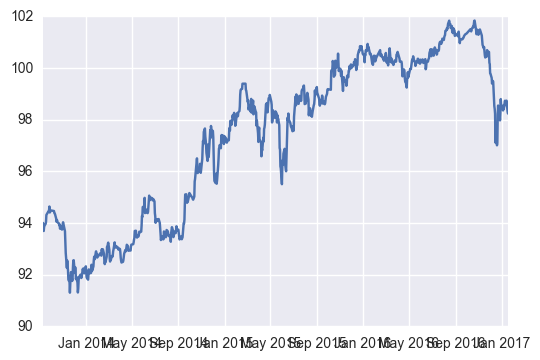

In [101]:
g = plt.plot(raw_df.index, raw_df["close"], markevery=long_markers)

In [33]:
(1 + df["port_avg"]).cumprod()

2013-09-30    1.000000
2013-10-31    1.000000
2013-11-29    1.000000
2013-12-31    1.000000
2014-01-31    1.000000
2014-02-28    1.000000
2014-03-31    1.000000
2014-04-30    0.977073
2014-05-30    0.763785
2014-06-30    0.789531
2014-07-31    0.652779
2014-08-29    0.663439
2014-09-30    0.810809
2014-10-31    0.908767
2014-11-28    1.079702
2014-12-31    1.055967
2015-01-30    1.098065
2015-02-27    1.239569
2015-03-31    0.987310
2015-04-30    1.160689
2015-05-29    0.873625
2015-06-30    0.757287
2015-07-31    0.802339
2015-08-31    0.838706
2015-09-30    0.836681
2015-10-30    0.893959
2015-11-30    0.910094
2015-12-31    0.945800
2016-01-29    0.937790
2016-02-29    0.938327
2016-03-31    0.941267
2016-04-29    0.834814
2016-05-31    0.759107
2016-06-30    0.785002
2016-07-29    0.851252
2016-08-31    0.877710
2016-09-30    0.884833
2016-10-31    0.876406
2016-11-30    0.685014
2016-12-30    0.892715
2017-01-31    0.916736
Freq: BM, Name: port_avg, dtype: float64

In [34]:
print("Sharpe Ratop = " + str(pf.empyrical.sharpe_ratio(df["port_avg"], period="monthly")))

Sharpe Ratop = 0.135327629033


In [35]:
print("Max Drawdown = " + str(pf.empyrical.max_drawdown(df["port_avg"])))

Max Drawdown = -0.447377477985


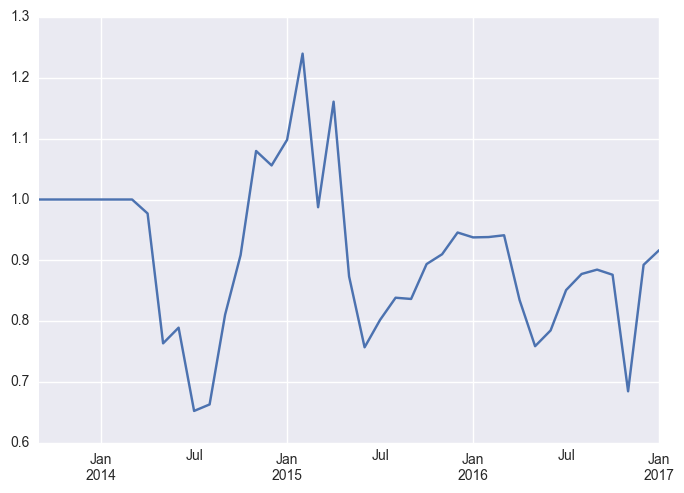

In [36]:
(1 + df["port_avg"]).cumprod().plot()

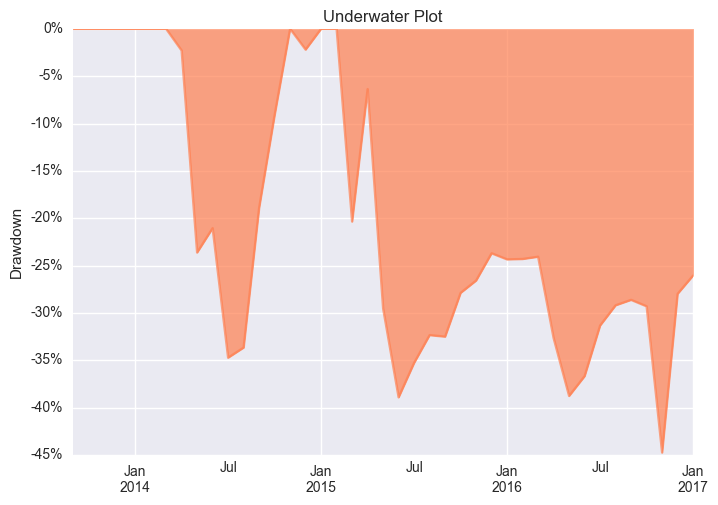

In [37]:
pf.plot_drawdown_underwater(df["port_avg"])

In [38]:
pf.empyrical.sharpe_ratio(ret_m_index[contract].pct_change(), period="monthly")

0.36474612965742692

In [39]:
pf.empyrical.max_drawdown(ret_m_index[contract].pct_change())

-0.030591602111806532

In [420]:
ret_tsmom.head(n=15)

,return,vol,short-term,medium-term,long-term
2005-01-31,1.000000,0.198482,0.000000,0.000000,0.000000
2005-02-28,1.039989,0.251732,0.000000,0.000000,0.000000
2005-03-31,0.942203,0.214973,-5.325174,0.000000,0.000000
2005-04-29,0.932395,0.226099,14.946187,0.000000,0.000000
2005-05-31,0.855946,0.210040,-1.544531,-1.093289,0.000000
2005-06-30,0.878686,0.275895,-7.781810,3.094831,0.000000
2005-07-29,0.888164,0.258172,-0.861181,0.610494,0.000000
2005-08-31,0.927916,0.240130,4.879505,-2.423480,0.000000
2005-09-30,0.917392,0.222430,-2.087870,-0.793089,0.000000
2005-10-31,0.876282,0.208119,-1.343177,-2.344476,0.000000


In [421]:
ret_tsmom["pct_return"] = ret_tsmom["return"].pct_change(1)

In [422]:
ret_tsmom.dropna(inplace=True)

In [423]:
ret_tsmom = ret_tsmom[12:] # drop firt 12 rows

In [424]:
ret_tsmom.head()

,return,vol,short-term,medium-term,long-term,pct_return
2006-02-28,1.053010,0.167146,-1.265192,0.816429,0.714934,0.043000
2006-03-31,1.061088,0.158151,-1.966185,-0.653684,21.724357,0.007671
2006-04-28,1.172347,0.159171,32.040799,0.206290,2.629344,0.104854
2006-05-31,1.365451,0.223444,1.434711,2.112481,3.299627,0.164716
2006-06-30,1.393963,0.239565,-1.563219,0.102559,-0.026573,0.020881


# 回归并检验

In [426]:
X = ret_tsmom[["short-term", "medium-term", "long-term"]].copy()
X = sm.add_constant(X)
y = ret_tsmom["pct_return"]

In [427]:
model = sm.OLS(y, X).fit()

In [428]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             pct_return   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.057
Method:                 Least Squares   F-statistic:                     3.621
Date:                Tue, 17 Jan 2017   Prob (F-statistic):             0.0150
Time:                        12:13:56   Log-Likelihood:                 126.99
No. Observations:                 132   AIC:                            -246.0
Df Residuals:                     128   BIC:                            -234.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const           0.0166      0.008      2.019      0.046         0.000     0.033
short-term      0.0014      0.001      2.213      0.029         0.000     0.003
medium-term     0.0014      0.001      1.431      0.155        -0.001     0.003
long-term       0.0021      0.001      1.664      0.099        -0.000     0.005
==============================================================================
Omnibus:                        2.854   Durbin-Watson:                   1.711
Prob(Omnibus):                  0.240   Jarque-Bera (JB):                2.649
Skew:                          -0.141   Prob(JB):                        0.266
Kurtosis:                       3.634   Cond. No.                         13.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# plot

In [435]:
df = pd.read_csv("../data/momentum.csv")

In [436]:
df

,Contract,Sharpe,Max Drawdown
0,IF00.CFE,0.332078,-0.619283
1,CU03.SHF,0.695599,-0.693016
2,A00.DCE,0.240146,-0.790870
3,I00.DCE,0.305706,-0.491375
4,IC00.CFE,0.346312,-0.092960
5,IM00.SHF,0.806841,0.000000
6,J00.DCE,0.755250,-0.533320
7,JD00.DCE,-0.191035,-0.328186
8,JM00.DCE,0.681660,-0.394231
9,L00.DCE,-0.087980,-0.809077


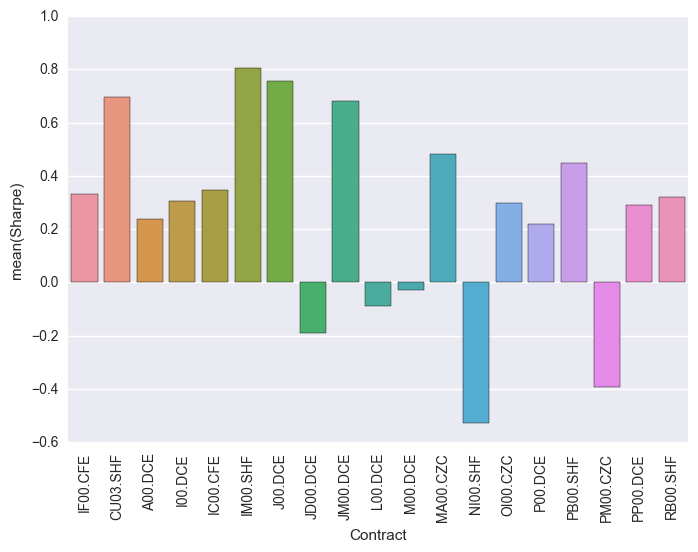

In [446]:
g = sns.barplot(x="Contract", y="Sharpe", data=df)
for item in g.get_xticklabels():
    item.set_rotation(90)